In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
users_df = pd.read_csv('users_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {users_df.shape}")
print(f"\nFirst few rows:")
print(users_df.head())
print(f"\nData types:")
print(users_df.dtypes)
print(f"\nMissing values:")
print(users_df.isnull().sum())

Dataset shape: (2000, 14)

First few rows:
     id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   

                    address  latitude  longitude per_capita_income  \
0             462 Rose Lane     34.15    -117.76            $29278   
1    3606 Federal Boulevard     40.76     -73.74            $37891   
2           766 Third Drive     34.02    -117.89            $22681   
3          3 Madison Street     40.71     -73.99           $163145   
4  9620 Valley Stream Drive     37.76    -122.44            $53797   

  yearly_income total_debt  credit_score  num_credit_cards  
0        $59696    $127613          

In [3]:
money_cols = [
    "per_capita_income",
    "yearly_income",
    "total_debt"
]

for col in money_cols:
    # Only clean if column exists
    if col in users_df.columns:
        users_df[col] = (
            users_df[col]
            .astype(str)
            .str.replace(r"[\$,]", "", regex=True)
            .astype(float)
        )

In [4]:
tran_df = pd.read_csv('transactions_2019data.csv')

In [5]:
tran_df.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

In [6]:
money_cols = [
    "amount",
]

for col in money_cols:
    # Only clean if column exists
    if col in tran_df.columns:
        tran_df[col] = (
            tran_df[col]
            .astype(str)
            .str.replace(r"[\$,]", "", regex=True)
            .astype(float)
        )

In [7]:
fraud_df = pd.read_json('fraud_labels.json')

In [8]:
fraud_df["fraud"] = (
    fraud_df["fraud"]
        .astype("string")
        .str.strip()
        .str.lower()
        .map({"yes": 1, "no": 0})
        .astype("int64")
)

In [9]:
#merging transaction data with fraud labels
tran_fraud_df = tran_df.merge(
    fraud_df,
    left_on="id",
    right_on="transaction_id",
    how="left"
)

# If fraud is missing, assume non-fraud
tran_fraud_df["fraud"] = tran_fraud_df["fraud"].fillna(0)


In [10]:
transaction_summary = tran_fraud_df.groupby("client_id").agg(
    total_transactions=("id", "count"),
    avg_transaction_amount=("amount", "mean"),
    max_transaction_amount=("amount", "max"),
    total_transaction_amount=("amount", "sum"),
    error_count=("errors", lambda x: x.notna().sum())
).reset_index()


In [11]:
fraud_summary = tran_fraud_df.groupby("client_id").agg(
    fraud_count=("fraud", "sum"),
    fraud_ratio=("fraud", "mean")
).reset_index()


In [12]:
users_augmented = users_df.merge(
    transaction_summary,
    left_on="id",
    right_on="client_id",
    how="left"
)

users_augmented = users_augmented.merge(
    fraud_summary,
    left_on="id",
    right_on="client_id",
    how="left"
)


In [13]:
users_augmented = users_augmented.drop(columns=["client_id_x", "client_id_y"])


In [14]:
users_augmented[
    ["total_transactions", "avg_transaction_amount",
     "max_transaction_amount", "total_transaction_amount",
     "error_count", "fraud_count", "fraud_ratio"]
] = users_augmented[
    ["total_transactions", "avg_transaction_amount",
     "max_transaction_amount", "total_transaction_amount",
     "error_count", "fraud_count", "fraud_ratio"]
].fillna(0)


In [15]:
features = [
    "current_age",
    "retirement_age",
    "per_capita_income",
    "yearly_income",
    "total_debt",
    "credit_score",
    "num_credit_cards",
    "total_transactions",
    "avg_transaction_amount",
    "fraud_ratio"
]

X_final = users_augmented[features]


In [16]:
scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_final)


In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_final)

print(f"PCA transformation complete")
print(f"PC1 explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains: {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

PCA transformation complete
PC1 explains: 26.02% of variance
PC2 explains: 24.35% of variance
Total variance explained: 50.37%


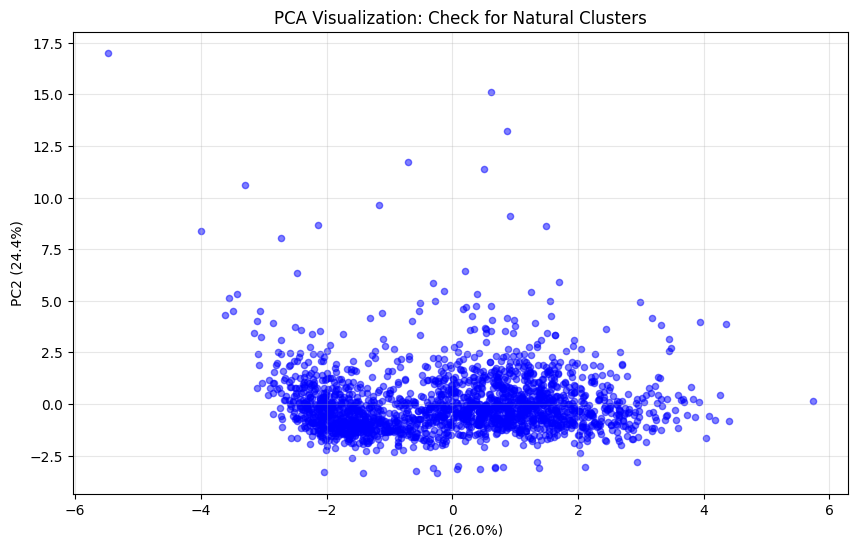

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=20, c='blue')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Visualization: Check for Natural Clusters")
plt.grid(True, alpha=0.3)
plt.show()

(ChatGPT 5.2, 2025)
Prompt: I have a dataset which i am doing clustering on, i want to calculate the hopkins statistic score to check the clustering tendency, what would be the code to do that in python? explsin what u do in every line and the parameters so that I know what to replace with my own data

In [19]:
def calculate_hopkins_statistic(X, sample_size=100):
  
    # Ensure sample size is not larger than data
    n = len(X)
    sample_size = min(sample_size, n // 10)
    
    # Randomly sample points from the dataset
    rand_idx = np.random.choice(n, sample_size, replace=False)
    X_sample = X[rand_idx]
    
    # Generate random points within the bounding box of the data
    X_min, X_max = X.min(axis=0), X.max(axis=0)
    X_random = np.random.uniform(X_min, X_max, (sample_size, X.shape[1]))
    
    # Find nearest neighbors in actual data
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    distances_sample, _ = nbrs.kneighbors(X_sample)
    u = distances_sample[:, 1]  
    
    # Find nearest neighbors for random points
    nbrs_random = NearestNeighbors(n_neighbors=1).fit(X)
    distances_random, _ = nbrs_random.kneighbors(X_random)
    w = distances_random[:, 0] 
    
    # Calculate Hopkins statistic
    H = np.sum(w) / (np.sum(u) + np.sum(w))
    return H


In [20]:
H_final = calculate_hopkins_statistic(X_scaled_final)
print(f"Hopkins Statistic (augmented data): {H_final:.4f}")


Hopkins Statistic (augmented data): 0.8709


(ChatGPT 5.2, 2025)
Prompt: how can i generate the elbow method graph and the plot the within cluster sum of squares for different k values, include comments of what i need to replace with my own data 

In [21]:
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled_final)
    wcss.append(kmeans.inertia_)

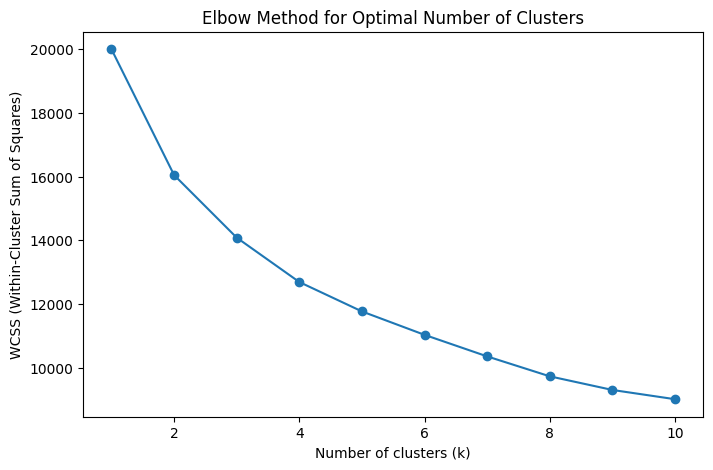

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.show()


In [23]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled_final)

sil_score = silhouette_score(X_scaled_final, labels)
print(f"Silhouette Score for k={k}: {sil_score:.3f}")

Silhouette Score for k=4: 0.225


In [24]:
users_augmented["kmeans_cluster_label"] = labels

In [25]:
users_augmented["kmeans_cluster_label"].value_counts()

kmeans_cluster_label
3    968
0    787
2    128
1    117
Name: count, dtype: int64

In [26]:
cluster_means = (
    users_augmented
    .groupby("kmeans_cluster_label")[X_final.columns]
    .mean()
)

cluster_means

,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,total_transactions,avg_transaction_amount,fraud_ratio
kmeans_cluster_label,,,,,,,,,,
0,32.994917,65.695044,21242.247776,42955.659466,68419.697586,701.856417,1.993647,38.306226,1.823880,0.000001
1,56.555556,66.769231,21189.897436,40310.589744,49896.350427,716.427350,4.128205,747.170940,42.728439,0.010733
2,44.132812,66.156250,51548.632812,103743.343750,154844.226562,705.687500,3.007812,758.289062,46.400895,0.000761
3,54.287190,66.625000,21166.078512,40940.261364,49499.123967,715.865702,3.831612,976.589876,41.467270,0.000312


In [27]:
cluster_stds = (
    users_augmented
    .groupby("kmeans_cluster_label")[X_final.columns]
    .std()
)

cluster_stds


,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,total_transactions,avg_transaction_amount,fraud_ratio
kmeans_cluster_label,,,,,,,,,,
0,14.195920,3.774970,6882.677701,14030.977449,41496.215884,69.816050,1.103411,158.498365,7.539847,0.000032
1,15.604732,3.472514,7192.637063,16245.210768,44952.546639,67.931928,1.831423,249.880775,15.743542,0.004493
2,15.548436,4.265661,21736.686205,41581.306560,92168.731136,73.047256,1.709151,599.086932,36.747895,0.001964
3,16.019061,3.373183,6648.989214,13993.856886,39296.267615,63.476795,1.451581,509.472556,16.311850,0.001066


In [28]:
cluster_summary = (
    users_augmented
    .groupby("kmeans_cluster_label")[X_final.columns]
    .agg(["mean", "std"])
)

cluster_summary


current_age            retirement_age            \
                            mean        std           mean       std   
kmeans_cluster_label                                                   
0                      32.994917  14.195920      65.695044  3.774970   
1                      56.555556  15.604732      66.769231  3.472514   
2                      44.132812  15.548436      66.156250  4.265661   
3                      54.287190  16.019061      66.625000  3.373183   

                     per_capita_income                yearly_income  \
                                  mean           std           mean   
kmeans_cluster_label                                                  
0                         21242.247776   6882.677701   42955.659466   
1                         21189.897436   7192.637063   40310.589744   
2                         51548.632812  21736.686205  103743.343750   
3                         21166.078512   6648.989214   40940.261364   

                                       total_debt               credit_score  \
                               std           mean           std         mean   
kmeans_cluster_label                                                           
0                     14030.977449   68419.697586  41496.215884   701.856417   
1                     16245.210768   49896.350427  44952.546639   716.427350   
2                     41581.306560  154844.226562  92168.731136   705.687500   
3                     13993.856886   49499.123967  39296.267615   715.865702   

                                num_credit_cards           total_transactions  \
                            std             mean       std               mean   
kmeans_cluster_label                                                            
0                     69.816050         1.993647  1.103411          38.306226   
1                     67.931928         4.128205  1.831423         747.170940   
2                     73.047256         3.007812  1.709151         758.289062   
3                     63.476795         3.831612  1.451581         976.589876   

                                 avg_transaction_amount             \
                             std                   mean        std   
kmeans_cluster_label                                                 
0                     158.498365               1.823880   7.539847   
1                     249.880775              42.728439  15.743542   
2                     599.086932              46.400895  36.747895   
3                     509.472556              41.467270  16.311850   

                     fraud_ratio            
                            mean       std  
kmeans_cluster_label                        
0                       0.000001  0.000032  
1                       0.010733  0.004493  
2                       0.000761  0.001964  
3                       0.000312  0.001066

(ChatGPT 5.2, 2025)
Prompt: I have my data in clusters and found the summary statistics, i just want to visualize each cluster its own bar graph to show the different features and the mean.

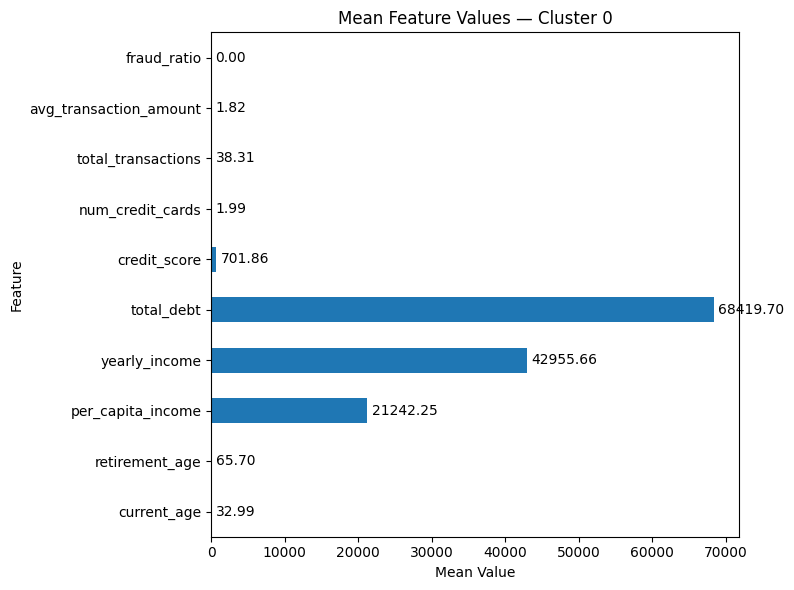

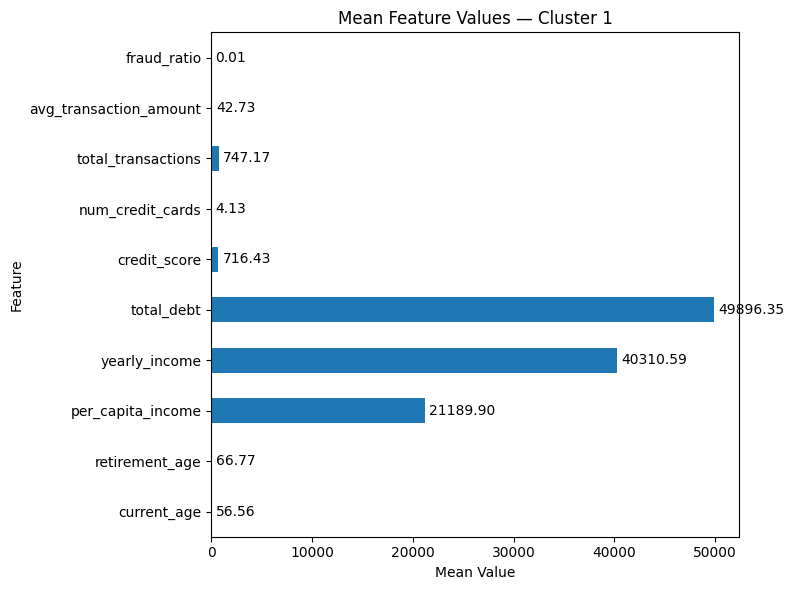

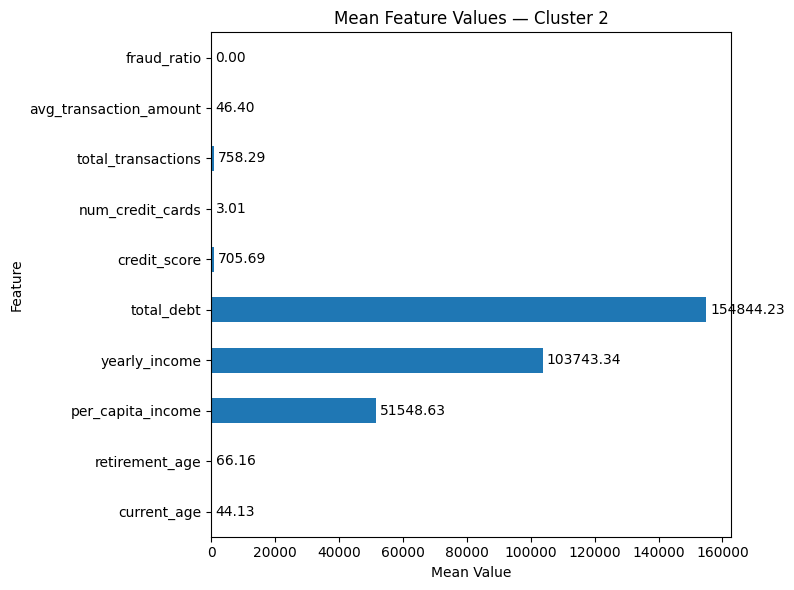

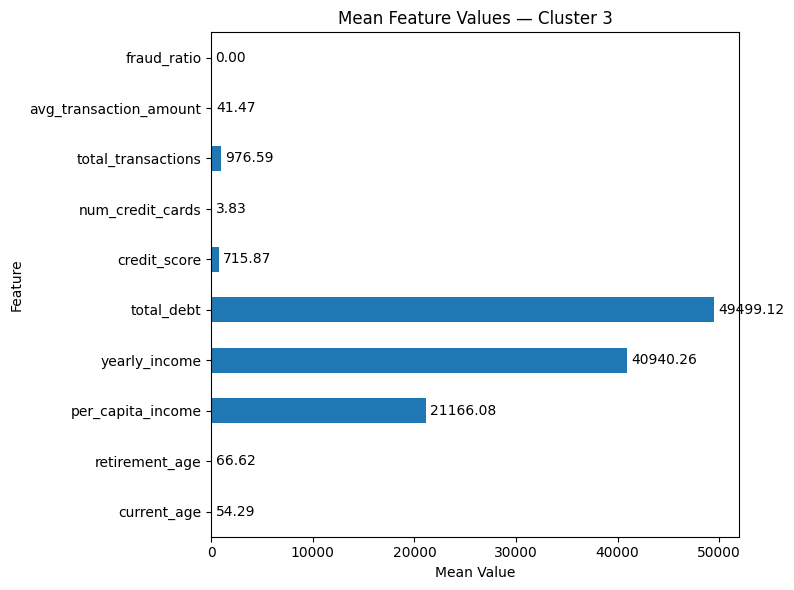

In [29]:
for cluster in cluster_means.index:
    ax = cluster_means.loc[[cluster]].T.plot(
        kind="barh",
        figsize=(8, 6),
        legend=False,
        title=f"Mean Feature Values — Cluster {cluster}"
    )

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3)

    plt.xlabel("Mean Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [30]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=1.5,
    min_samples=10
)

dbscan_labels = dbscan.fit_predict(X_scaled_final)

In [31]:
users_augmented["dbscan_label"] = dbscan_labels


In [32]:
users_augmented["dbscan_label"].value_counts()


dbscan_label
 0    1501
-1     499
Name: count, dtype: int64

In [33]:
outliers = users_augmented[users_augmented["dbscan_label"] == -1]
non_outliers = users_augmented[users_augmented["dbscan_label"] != -1]


In [34]:
comparison = (
    users_augmented
    .groupby(users_augmented["dbscan_label"] == -1)[X_final.columns]
    .mean()
)

comparison.index = ["Non-Outliers", "Outliers"]
comparison


,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,total_transactions,avg_transaction_amount,fraud_ratio
Non-Outliers,42.475683,66.324450,20954.248501,41841.904730,60343.786809,710.977348,2.872085,468.863424,21.181628,0.000065
Outliers,54.162325,65.975952,29722.503006,57368.867735,73834.396794,705.995992,3.677355,914.232465,41.524308,0.003123


In [35]:
outliers["fraud_ratio"].describe()

count    499.000000
mean       0.003123
std        0.004987
min        0.000000
25%        0.000000
50%        0.000000
75%        0.005329
max        0.030457
Name: fraud_ratio, dtype: float64